### Instalacja potrzebnych bibliotek

In [7]:
pip install ipywidgets #interaktywne widżety HTML dla notebooków Jupyter i jądra IPython

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#interaktywne'


In [2]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Importowanie wymaganych bibliotek

In [17]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania.
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

##### Import bibliotek do stworzenia sieci LSTM

In [18]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)

### Wczytanie bazy

In [19]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
#data = pd.read_csv('/Users/luke/Documents/notowania/csv/jnj_us_d.csv')
data = pd.read_csv('C:/Users/lukiu/Desktop/notowania/csv/jnj_us_d.csv')

### Podzial na zbiór treningowy i testowy

In [20]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(13418, 6)


In [21]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(8050, 6)


In [22]:
# zbiór testowy
ratio = 0.4
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(5367, 6)


In [23]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
count,8050.000000,8050.000000,8050.000000,8050.000000,8.050000e+03
mean,7.134299,7.210753,7.055696,7.138187,6.271724e+06
std,10.172603,10.285243,10.055938,10.179933,5.895566e+06
min,0.340169,0.347260,0.326077,0.333098,1.219074e+05
25%,0.836204,0.843362,0.830761,0.836204,2.451711e+06
50%,1.651120,1.669075,1.637200,1.654705,5.347883e+06
75%,7.462870,7.525170,7.377950,7.461082,8.314602e+06
max,42.700600,43.012500,42.297600,42.573100,2.041288e+08


In [24]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [25]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [26]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [27]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

In [28]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Uczenie modelu

In [29]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2)) 
  model.add(Dense(8))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=10, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



## Ewaluacja modelu

In [30]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict



In [31]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [32]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/10
642/642 [==============================] - 3s 2ms/step - loss: 8.2485e-05 - val_loss: 0.1080
Epoch 2/10
642/642 [==============================] - 1s 2ms/step - loss: 5.4544e-04 - val_loss: 0.0743
Epoch 3/10
642/642 [==============================] - 1s 2ms/step - loss: 1.1600e-04 - val_loss: 0.0621
Epoch 4/10
642/642 [==============================] - 1s 2ms/step - loss: 8.0142e-05 - val_loss: 0.0943
Epoch 5/10
642/642 [==============================] - 1s 2ms/step - loss: 7.3480e-05 - val_loss: 0.0979
Epoch 6/10
642/642 [==============================] - 1s 2ms/step - loss: 7.4290e-05 - val_loss: 0.1188
Epoch 7/10
642/642 [==============================] - 1s 2ms/step - loss: 6.7142e-05 - val_loss: 0.1228
Epoch 8/10
642/642 [==============================] - 1s 2ms/step - loss: 7.2945e-05 - val_loss: 0.1318
Epoch 9/10
642/642 [==============================] - 1s 2ms/step - loss: 6.8250e-05 - val_loss: 0.1256
Epoch 10/10
642/642 [==============================] - 1s 2ms/st

In [33]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


In [34]:

evaluation_model(history,X_train, X_test, Y_train)

50/50 [==============================] - 0s 714us/step
Train Mean Absolute Error: 1.2274889466039753
Train Root Mean Squared Error: 1.2702782426813388


(array([[ 0.46784   ,  0.48895402,  0.48194199, ..., 11.6384003 ,
         11.6384003 , 11.37560024]]),
 array([[ 1.3716916,  1.431776 ,  1.4114656, ...,  1.4425523,  1.4159409,
          1.4028934],
        [ 1.3645221,  1.4246614,  1.4040279, ...,  1.4351118,  1.4086828,
          1.3958763],
        [ 1.3616726,  1.4216052,  1.4009643, ...,  1.4321145,  1.4056151,
          1.3927597],
        ...,
        [11.530562 , 11.510597 , 11.521338 , ..., 11.513979 , 11.543569 ,
         11.535028 ],
        [11.586095 , 11.565835 , 11.576487 , ..., 11.568939 , 11.599162 ,
         11.588879 ],
        [11.643544 , 11.6245165, 11.634746 , ..., 11.627376 , 11.658164 ,
         11.64912  ]], dtype=float32))

In [35]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

50/50 [==============================] - 0s 735us/step
Train Mean Absolute Error: 1.2274889466039753
Train Root Mean Squared Error: 1.2702782426813388


In [36]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



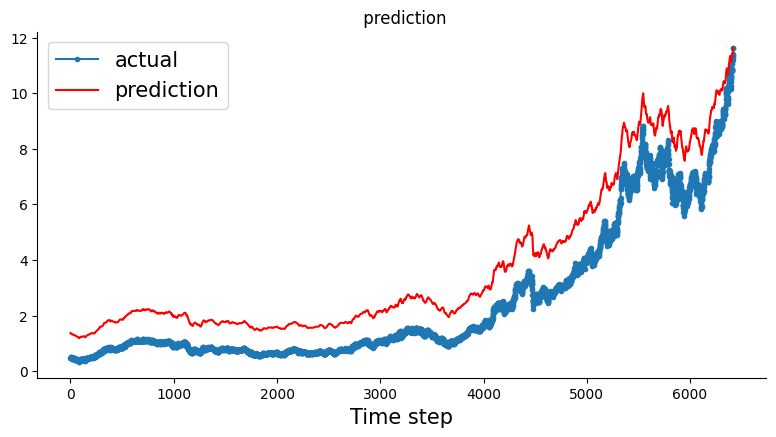

In [37]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict) # niebieska- z csv wiersze i do nich wartości z pliku excel (na podstawie ratio nie cale 2849 tylko 0.6 z tego); czerwone- dla poszczegolnych wierszy błędy; model dobrze się uczy

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [38]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.256501   0.25705734 0.25369322]
 [0.25705734 0.25369322 0.25441292]
 [0.25369322 0.25441292 0.24976802]
 ...
 [0.99138975 0.9824243  0.9929428 ]
 [0.9824243  0.9929428  1.0000001 ]
 [0.9929428  1.0000001  0.99628556]]


In [39]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/10
644/644 [==============================] - 3s 2ms/step - loss: 6.9079e-05 - val_loss: 0.0910
Epoch 2/10
644/644 [==============================] - 1s 2ms/step - loss: 6.9289e-04 - val_loss: 0.0328
Epoch 3/10
644/644 [==============================] - 1s 2ms/step - loss: 2.2338e-04 - val_loss: 0.0095
Epoch 4/10
644/644 [==============================] - 1s 2ms/step - loss: 9.5438e-05 - val_loss: 0.0048
Epoch 5/10
644/644 [==============================] - 1s 2ms/step - loss: 6.2713e-05 - val_loss: 0.0015
Epoch 6/10
644/644 [==============================] - 1s 2ms/step - loss: 5.8759e-05 - val_loss: 0.0024
Epoch 7/10
644/644 [==============================] - 1s 2ms/step - loss: 5.4128e-05 - val_loss: 0.0044
Epoch 8/10
644/644 [==============================] - 1s 2ms/step - loss: 5.0573e-05 - val_loss: 0.0071
Epoch 9/10
644/644 [==============================] - 1s 2ms/step - loss: 6.5881e-05 - val_loss: 0.0069
Epoc

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [40]:
# wyświetlenie liczby kolumn i wierszy; 2849:1346= 2,1 , a więc 20% (a wcześniej ratio 0.8), więc tak przyjął; model treningowy z predykcją (czerwona linia na wykresie)
train_predict.shape

(6419, 8)

In [41]:
error_look_back[3]["MSE"]

[1.6317562698643688,
 1.601779453949555,
 1.6270674208300064,
 1.457162545249997,
 1.4938349293564184,
 1.671545568531322,
 1.516745961240589,
 1.5804657805202476,
 1.593210982284078,
 1.4701596159087975]

In [42]:
error_look_back[3]["MAE"]

[1.5780293368816691,
 1.4990442016511638,
 1.553587934304998,
 1.3861638516030852,
 1.4119790043762255,
 1.590723824255413,
 1.4374661186011712,
 1.5133298192267426,
 1.5218995386147318,
 1.4094604559664006]

In [43]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[1.0565453028715077, 1.0740218002576856, 1.1529041944660148, 1.1654149805089091, 1.240413894695834, 1.3191554752980907, 1.4734754174448388, 1.6221136376103018, 1.7664445661354633, 1.8663759589783677]


<Axes: >

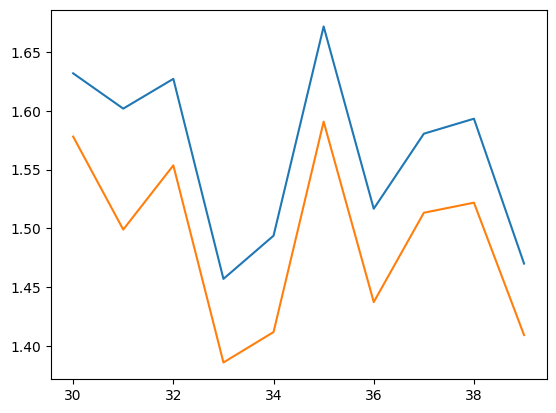

In [44]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3 
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


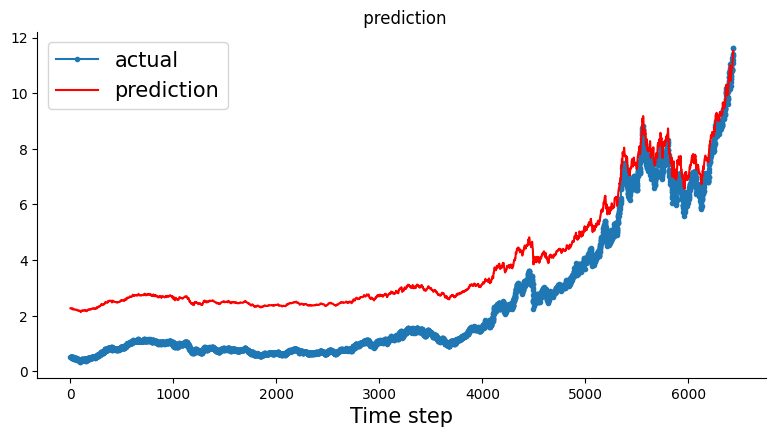

In [45]:
batch_index = 9 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3 #jak to wyrzucimy, to tez bedzie dzialac
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [46]:
error_look_back[3]["Y_trains"][0]

array([[ 0.510823  ,  0.51719802,  0.51719802, ..., 11.6384003 ,
        11.37560024, 11.0725006 ]])